<a href="https://colab.research.google.com/github/galitneu/auto-eda-tool/blob/main/9342.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- שלב 0: ייבוא ספריות וחיבור לגוגל דרייב ---
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# חיבור סביבת העבודה לגוגל דרייב
from google.colab import drive
drive.mount('/content/drive')

# --- שלב 1 עד 6: הכנת הנתונים ---
# (כל קוד הכנת הנתונים נשאר זהה)
DRIVE_PATH = '/content/drive/MyDrive/KaggleProject/'
df_train_raw = pd.read_csv(f'{DRIVE_PATH}Train.csv', low_memory=False)
df_valid_raw = pd.read_csv(f'{DRIVE_PATH}Valid.csv', low_memory=False)
df_train_raw['saledate'] = pd.to_datetime(df_train_raw['saledate'])
df_valid_raw['saledate'] = pd.to_datetime(df_valid_raw['saledate'])
df_train_raw['saleYear'] = df_train_raw['saledate'].dt.year
df_valid_raw['saleYear'] = df_valid_raw['saledate'].dt.year
df_train_raw = df_train_raw[df_train_raw['saleYear'] >= 2008].copy()
df_valid_raw = df_valid_raw[df_valid_raw['saleYear'] >= 2008].copy()
train_labels = df_train_raw['SalePrice'].copy()
df_train_raw = df_train_raw.drop('SalePrice', axis=1)
df_train_raw['source'] = 'train'
df_valid_raw['source'] = 'valid'
df_combined = pd.concat([df_train_raw, df_valid_raw], ignore_index=True, sort=False)
df_combined = df_combined.drop('saledate', axis=1)
df_combined['machineAge'] = df_combined['saleYear'] - df_combined['YearMade']
valid_age_median = df_combined[df_combined['YearMade'] != 1000]['machineAge'].median()
df_combined.loc[df_combined['YearMade'] == 1000, 'machineAge'] = valid_age_median
df_combined['fiProductClassDesc'] = df_combined['fiProductClassDesc'].fillna('')
keywords_to_extract = ['excavator', 'dozer', 'loader', 'crawler', 'wheel', 'track']
for keyword in keywords_to_extract:
    df_combined[f'is_{keyword}'] = df_combined['fiProductClassDesc'].str.contains(keyword, case=False).astype(int)
df_combined['is_YearMade_1000'] = (df_combined['YearMade'] == 1000).astype(int)
df_combined['is_Hours_Zero'] = (df_combined['MachineHoursCurrentMeter'] == 0).astype(int)
df_combined['is_ProductGroup_5'] = (df_combined['ProductGroup'] == 5).astype(int)
df_combined['is_ProductGroup_2'] = (df_combined['ProductGroup'] == 2).astype(int)
numeric_cols_missing = ['MachineHoursCurrentMeter', 'auctioneerID']
for col in numeric_cols_missing:
    df_combined[col + '_is_missing'] = df_combined[col].isnull()
    median_val = df_combined[col].median()
    df_combined[col] = df_combined[col].fillna(median_val)
categorical_cols_missing = [col for col in df_combined.columns if pd.api.types.is_object_dtype(df_combined[col]) and df_combined[col].isnull().sum() > 0]
for col in categorical_cols_missing:
    df_combined[col] = df_combined[col].fillna('missing')
source_col = df_combined['source']
df_combined = df_combined.drop('source', axis=1)
cols_to_drop = []
for col_name in df_combined.columns:
    if pd.api.types.is_object_dtype(df_combined[col_name]):
        num_unique_values = df_combined[col_name].nunique()
        if num_unique_values <= 5:
            dummies = pd.get_dummies(df_combined[col_name], prefix=col_name)
            df_combined = pd.concat([df_combined, dummies], axis=1)
            cols_to_drop.append(col_name)
        else:
            df_combined[col_name] = pd.Categorical(df_combined[col_name]).codes
df_combined = df_combined.drop(columns=cols_to_drop)
df_combined['source'] = source_col
df_train_processed = df_combined[df_combined['source'] == 'train'].drop('source', axis=1).copy()
df_valid_processed = df_combined[df_combined['source'] == 'valid'].drop('source', axis=1).copy()
df_train_processed['SalePrice'] = train_labels.values
# --- סוף קוד ההכנה ---

# --- שלב 7: כוונון היפר-פרמטרים אחרון וממוקד (Grid Search) על דגימה ---
print("\n--- מתחיל חיפוש היפר-פרמטרים ממוקד (Grid Search)... ---")
val_year = 2011
train_time_split = df_train_processed[df_train_processed['saleYear'] <= val_year - 1]
val_time_split = df_train_processed[df_train_processed['saleYear'] == val_year]
X_train_time = train_time_split.drop('SalePrice', axis=1)
y_train_time = train_time_split['SalePrice']
X_val_time = val_time_split.drop('SalePrice', axis=1)
y_val_time = val_time_split['SalePrice']

# !!! התיקון כאן: יצירת דגימה קטנה יותר לחיפוש מהיר !!!
SAMPLE_SIZE = 20000
if len(X_train_time) > SAMPLE_SIZE:
    X_train_sample = X_train_time.sample(n=SAMPLE_SIZE, random_state=42)
    y_train_sample = y_train_time.loc[X_train_sample.index]
else:
    X_train_sample = X_train_time
    y_train_sample = y_train_time
print(f"--- Starting Grid Search on a sample of {len(X_train_sample)} rows ---")

# Grid for a focused, final search
param_grid = {
    'n_estimators': [150, 200],
    'max_features': [0.5, 'sqrt'],
    'max_depth': [20, 30],
    'min_samples_leaf': [3, 5]
}
gs_base_model = RandomForestRegressor(n_jobs=-1, random_state=42)
grid_search = GridSearchCV(estimator=gs_base_model, param_grid=param_grid,
                           cv=3, verbose=2, n_jobs=1)

# !!! הרצת החיפוש על הדגימה הקטנה, לא על כל הסט !!!
grid_search.fit(X_train_sample, y_train_sample)

print("\nהפרמטרים הטובים ביותר שנמצאו:")
print(grid_search.best_params_)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

best_model = grid_search.best_estimator_
val_preds = best_model.predict(X_val_time)
val_rmse_score = rmse(y_val_time, val_preds)
print(f"\nערך הפיספוס (RMSE) עם המודל המכוונן הוא: ${val_rmse_score:,.2f}")

# --- שלב 8: אימון מודל סופי על כל הנתונים ---
print("\n" + "="*50 + "\n--- שלב סופי: אימון מחדש על כל נתוני האימון ---")
X_full_train = df_train_processed.drop('SalePrice', axis=1)
y_full_train = df_train_processed['SalePrice']
final_model = RandomForestRegressor(n_jobs=-1, random_state=42, **grid_search.best_params_)
final_model.fit(X_full_train, y_full_train)
print("אימון המודל הסופי והמכוונן הושלם.")

# --- שלב 9: יצירת קובץ הגשה ---
print("\n" + "="*50 + "\n--- יצירת קובץ הגשה באמצעות המודל הסופי ---")
train_cols = set(X_full_train.columns)
valid_cols = set(df_valid_processed.columns)
missing_in_valid = list(train_cols - valid_cols)
for c in missing_in_valid:
    df_valid_processed[c] = 0
df_valid_processed = df_valid_processed[X_full_train.columns]
valid_predictions = final_model.predict(df_valid_processed)
df_submission = pd.DataFrame({'SalesID': df_valid_raw['SalesID'], 'SalePrice': valid_predictions})
submission_filename = f'{DRIVE_PATH}submission.csv'
df_submission.to_csv(submission_filename, index=False)
print(f"\nקובץ ההגשה '{submission_filename}' נשמר בהצלחה ב-Google Drive!")
print(df_submission.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

--- מתחיל חיפוש היפר-פרמטרים ממוקד (Grid Search)... ---
--- Starting Grid Search on a sample of 20000 rows ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=3, n_estimators=150; total time=   7.0s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=3, n_estimators=150; total time=   7.8s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=3, n_estimators=150; total time=   7.9s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=3, n_estimators=200; total time=   9.8s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=3, n_estimators=200; total time=  10.2s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=3, n_estimators=200; total time=  10.2s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=5, n_estimators=150; total time=   7.3s
[CV] END max

--- Preparing the Detective's Report ---

--- Top 10 Worst Predictions (Largest Dollar Error) ---


,SalesID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,...,Differential_Type_missing,Steering_Controls_Command Control,Steering_Controls_Conventional,Steering_Controls_Four Wheel Standard,Steering_Controls_Wheel,Steering_Controls_missing,SalePrice_True,SalePrice_Pred,Error,Abs_Error
21176,1350808,1129,132,1.0,1999,82.0,444,152,19,114,...,True,False,False,False,False,True,105000,30331.043676,74668.956324,74668.956324
114722,2531961,4139,149,1.0,1982,0.0,1999,589,49,114,...,True,False,False,False,False,True,117500,48632.985741,68867.014259,68867.014259
145025,6265877,4149,149,1.0,1996,82.0,2033,592,89,114,...,True,False,False,False,False,True,9500,78240.801439,-68740.801439,68740.801439
114728,2531969,4139,149,1.0,1983,0.0,1999,589,49,114,...,True,False,False,False,False,True,115000,50141.685819,64858.314181,64858.314181
15952,1219396,11907,121,3.0,1000,0.0,1774,570,13,12,...,True,False,False,False,False,True,120000,55788.434061,64211.565939,64211.565939
114725,2531965,4139,149,1.0,1983,0.0,1999,589,49,114,...,True,False,False,False,False,True,112500,50072.437142,62427.562858,62427.562858
2676,1160387,14430,121,3.0,2005,4058.0,1238,348,36,114,...,True,False,False,False,False,True,135000,72630.511030,62369.488970,62369.488970
151751,6319851,18180,149,1.0,2005,82.0,2180,657,19,114,...,True,False,False,False,False,True,12500,73770.956414,-61270.956414,61270.956414
144502,6262962,1661,149,1.0,1998,82.0,2009,589,102,114,...,True,False,False,False,False,True,127500,66364.949393,61135.050607,61135.050607
128060,2753193,18223,149,26.0,1000,2434.0,2460,770,160,114,...,True,False,False,False,False,True,135000,74139.427924,60860.572076,60860.572076



--- Average Error by Product Group ---


,Mean_Error,Mean_Abs_Error,Count
ProductGroup,,,
4,-75.849329,7144.827189,6568
1,265.983061,7133.773404,2165
5,634.030684,7027.135310,6011
3,1075.218264,6233.775847,9422
0,671.309990,2652.931656,6422
2,696.258103,1756.336133,4609



--- Visualizing Errors vs. True Sale Price ---


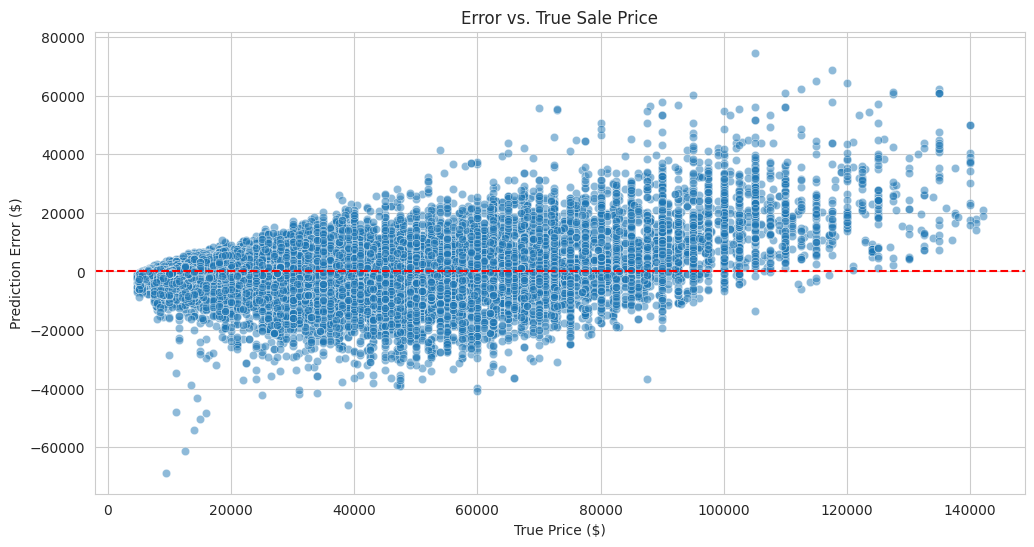

In [3]:
# First, ensure you have the necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# --- 1. Preparing the Data for Investigation ---
# This code assumes you have:
# X_val_time: Your validation features
# y_val_time: The true prices for the validation set
# val_preds: The model's predictions for the validation set

print("--- Preparing the Detective's Report ---")
# Create a new DataFrame to avoid changing the original data
analysis_df = X_val_time.copy()

# Add the true prices, the predictions, and the calculated errors
analysis_df['SalePrice_True'] = y_val_time
analysis_df['SalePrice_Pred'] = val_preds
analysis_df['Error'] = analysis_df['SalePrice_True'] - analysis_df['SalePrice_Pred']
analysis_df['Abs_Error'] = np.abs(analysis_df['Error'])


# --- 2. Identifying the Biggest Mistakes ---

# Sort the DataFrame by the absolute error to see the 10 worst predictions
print("\n--- Top 10 Worst Predictions (Largest Dollar Error) ---")
display(analysis_df.sort_values(by='Abs_Error', ascending=False).head(10))


# --- 3. Analyzing Errors by Category ---

# Check if the model is systematically biased for or against certain product groups
# A positive 'Mean Error' means the model, on average, under-predicts the price.
# A negative 'Mean Error' means the model, on average, over-predicts the price.
# We need to merge the 'ProductGroup' column from the original data to do this analysis
if 'ProductGroup' not in analysis_df.columns:
    # Assuming df_train_processed contains the original features before encoding
    analysis_df = analysis_df.merge(df_train_processed[['ProductGroup']], left_index=True, right_index=True, how='left')

if 'ProductGroup' in analysis_df.columns:
    error_by_group = analysis_df.groupby('ProductGroup').agg(
        Mean_Error=('Error', 'mean'),
        Mean_Abs_Error=('Abs_Error', 'mean'),
        Count=('Error', 'size')
    )

    print("\n--- Average Error by Product Group ---")
    display(error_by_group.sort_values(by='Mean_Abs_Error', ascending=False))
else:
    print("\n'ProductGroup' column not found for error analysis by category.")


# --- 4. Analyzing Errors Visually ---

print("\n--- Visualizing Errors vs. True Sale Price ---")
# Create a scatter plot to see if the error changes as the price increases
plt.figure(figsize=(12, 6))
sns.scatterplot(x='SalePrice_True', y='Error', data=analysis_df, alpha=0.5)
plt.title('Error vs. True Sale Price')
plt.xlabel('True Price ($)')
plt.ylabel('Prediction Error ($)')
plt.axhline(0, color='red', linestyle='--') # Add a line at zero error
plt.show()